In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys

# 导入我们在 03 中封装好的模型
# 确保 models.py 在当前目录下
try:
    from models import M2_GNN_Regressor, M3_Physics_Diffusion, DiffusionScheduler
except ImportError:
    print("❌ Error: models.py not found. Please run the %%writefile cell in Notebook 03.")

# --- 配置 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")

# --- 超参数 (针对 GPU 优化) ---
# 因为数据全在 GPU 上，我们可以使用极大的 Batch Size，这会极大提升速度
BATCH_SIZE = 2048  
LR = 1e-3
EPOCHS = 500 
MASK_RATIO_RANGE = (0.1, 0.9)  # 观测率 10% ~ 90%
NOISE_STD = 0.01               # 1% 量测噪声

# 路径
DATA_PATH = "../data/processed/cigre_lv_graph_dataset_v1.pt"
MODEL_SAVE_DIR = "../models/checkpoints"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

🚀 Device: cuda


In [9]:
print("🚀 Loading Dataset (Pre-normalized) to VRAM...")

# 1. 加载文件
try:
    data = torch.load(DATA_PATH, weights_only=False)
except TypeError:
    data = torch.load(DATA_PATH)

# 2. 提取数据并直接转入 GPU
train_idx = data['train_idx']
val_idx = data['val_idx']

# --- 关键修正：直接加载，不再进行 transform ---
# 硬盘里的数据已经是 Z-Score 分布 (Mean~0, Std~1)
full_p_train = data['Y_p'][train_idx].to(device)
full_v_train = data['Y_v'][train_idx].to(device)

full_p_val = data['Y_p'][val_idx].to(device)
full_v_val = data['Y_v'][val_idx].to(device)

# 3. 静态拓扑
static_edge_index = data['edge_index'].to(device)
static_edge_attr = data['edge_attr'].to(device)
N_NODES = data['n_nodes']

# 4. 验证一下数据范围，确保不需要再归一化
print(f"✅ Data Loaded on GPU.")
print(f"   Train P Range: [{full_p_train.min():.2f}, {full_p_train.max():.2f}] (Should be approx -3 to 3)")
print(f"   Train V Range: [{full_v_train.min():.2f}, {full_v_train.max():.2f}] (Should be approx -3 to 3)")
print(f"   Topology: {N_NODES} nodes, {static_edge_index.shape[1]} edges")


🚀 Loading Dataset (Pre-normalized) to VRAM...
✅ Data Loaded on GPU.
   Train P Range: [-3.02, 5.21] (Should be approx -3 to 3)
   Train V Range: [-3.52, 2.40] (Should be approx -3 to 3)
   Topology: 44 nodes, 86 edges


In [10]:
# Cell 3: Helper Functions (Fixed Device Issue)

def process_batch_with_curriculum(p_batch, v_batch, current_epoch, total_epochs):
    """
    带课程学习的数据处理函数。
    随着 epoch 增加，观测率(rho) 的下限会逐渐降低，任务变难。
    """
    B = p_batch.shape[0]
    Total_Nodes = B * N_NODES
    
    # 1. 扁平化
    p_flat = p_batch.view(-1, 1)
    v_flat = v_batch.view(-1, 1)
    
    # === 课程学习核心逻辑 ===
    START_MIN_OBS = 0.8
    END_MIN_OBS = 0.1
    
    if total_epochs > 0:
        progress = min(1.0, current_epoch / (total_epochs * 0.8))
    else:
        progress = 1.0
        
    current_min_obs = START_MIN_OBS - (START_MIN_OBS - END_MIN_OBS) * progress
    rho = np.random.uniform(current_min_obs, 0.9)
    # ========================
    
    mask = torch.rand(Total_Nodes, 1, device=device) < rho
    mask = mask.float()
    
    # 噪声注入
    noise_p = torch.randn_like(p_flat) * NOISE_STD
    noise_v = torch.randn_like(v_flat) * NOISE_STD
    p_meas = p_flat + noise_p
    v_meas = v_flat + noise_v
    
    p_input = p_meas * mask
    v_input = v_meas * mask
    q_input = p_input * 0.33
    
    condition = torch.cat([p_input, q_input, v_input, mask, mask, mask], dim=-1)
    batch_idx = torch.arange(B, device=device).repeat_interleave(N_NODES)
    
    return condition, v_flat, batch_idx, mask, rho

def physics_guided_loss(model, x_t, t_batch, t_expanded, condition, edge_index, edge_attr, batch_idx, noise_target, x_start_true, lambda_phy=0.5):
    """
    计算混合 Loss: L_total = L_mse(noise) + lambda * L_phy(x_0_hat)
    专用于扩散模型 M3。
    """
    # 1. 预测噪声
    noise_pred = model(x_t, t_batch, condition, edge_index, edge_attr, batch_idx)
    
    # 2. 基础 Loss
    loss_mse = nn.MSELoss()(noise_pred, noise_target)
    
    # 3. 物理约束 (Tweedie Formula)
    
    # --- 修复点：确保 alphas_cumprod 在正确的设备上 ---
    # model.scheduler.alphas_cumprod 可能在 CPU，强制转到 GPU
    alphas_cumprod = model.scheduler.alphas_cumprod.to(t_expanded.device)
    
    # 现在都在 GPU 上了，可以安全索引
    alpha_bar = alphas_cumprod[t_expanded].view(-1, 1)
    
    sqrt_alpha_bar = torch.sqrt(alpha_bar)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)
    
    # 反推 x_0
    x_0_hat = (x_t - sqrt_one_minus_alpha_bar * noise_pred) / sqrt_alpha_bar
    
    # 4. 物理一致性 Loss
    loss_phy = nn.MSELoss()(x_0_hat, x_start_true)
    
    # 5. 总 Loss
    total_loss = loss_mse + lambda_phy * loss_phy
    
    return total_loss, loss_mse.item(), loss_phy.item()

print("✅ Physics-Guided Helper Functions Defined (Device Fixed).")

✅ Physics-Guided Helper Functions Defined (Device Fixed).


In [11]:
# Cell 4: Verification (Updated for Curriculum Function)

print("🔍 Starting Verification...")

# Take 10 samples for testing
test_p = full_p_train[:10]
test_v = full_v_train[:10]

# Call the NEW function
# We pass current_epoch=0, total_epochs=100 to simulate the start of training
# It returns an extra value 'rho', so we need to unpack 5 values now.
cond, target, b_idx, mask, rho = process_batch_with_curriculum(test_p, test_v, current_epoch=0, total_epochs=100)

print(f"   Current Observability Ratio (rho): {rho:.4f}")

# --- Check A: Mask Leakage ---
input_p = cond[:, 0]
# Elements where mask is 0 should be 0
zeros_at_unmasked = input_p[mask.squeeze() == 0]
if torch.all(zeros_at_unmasked == 0):
    print("✅ Mask Logic: PASS (Unmasked values are strictly zero)")
else:
    # If not zero, print the first few non-zero values for debugging
    raise ValueError(f"❌ Mask Logic FAIL! Found non-zeros: {zeros_at_unmasked[:5]}")

# --- Check B: Noise Injection ---
mask_bool = mask.squeeze() == 1
input_v_masked = cond[mask_bool, 2]
target_v_masked = target.squeeze()[mask_bool]
mae_noise = torch.abs(input_v_masked - target_v_masked).mean().item()
print(f"   Noise Level (MAE): {mae_noise:.6f} (Expected approx {NOISE_STD})")

if mae_noise > 1e-6:
    print("✅ Noise Logic: PASS (Input is noisy)")
else:
    print("⚠️ Warning: Noise might be too small or zero.")

print("🎉 VERIFICATION SUCCESSFUL.")

🔍 Starting Verification...
   Current Observability Ratio (rho): 0.8419
✅ Mask Logic: PASS (Unmasked values are strictly zero)
   Noise Level (MAE): 0.008412 (Expected approx 0.01)
✅ Noise Logic: PASS (Input is noisy)
🎉 VERIFICATION SUCCESSFUL.


In [12]:
hidden_dim = 64

# M2: 回归
model_m2 = M2_GNN_Regressor(hidden_dim=hidden_dim).to(device)
opt_m2 = optim.Adam(model_m2.parameters(), lr=LR)

# M3: 扩散
model_m3 = M3_Physics_Diffusion(hidden_dim=hidden_dim).to(device)
opt_m3 = optim.Adam(model_m3.parameters(), lr=LR)

print("✅ Models Initialized.")

✅ Models Initialized.


In [13]:
# Cell 6: Physics-Guided Training Loop with Curriculum Learning

print(f"🚀 Starting Training (Physics + Curriculum Mode)...")

n_train = full_p_train.shape[0]
n_batches = int(np.ceil(n_train / BATCH_SIZE))

loss_history = {'m2': [], 'm3': [], 'm3_phy': []}
best_loss_m3 = float('inf') 

# 物理 Loss 权重 (建议 0.5 ~ 1.0)
LAMBDA_PHY = 0.2

# 进度条
epoch_pbar = tqdm(range(1, EPOCHS + 1), desc="Training", unit="epoch", dynamic_ncols=True)

for epoch in epoch_pbar:
    m2_losses = []
    m3_mse_losses = []
    m3_phy_losses = []
    obs_ratios = [] # 记录这一轮的观测率变化
    
    perm = torch.randperm(n_train, device=device)
    
    for i in range(n_batches):
        # A. 数据切片
        idx = perm[i*BATCH_SIZE : (i+1)*BATCH_SIZE]
        p_batch = full_p_train[idx]
        v_batch = full_v_train[idx]
        
        # B. 课程学习数据处理 (传入当前 epoch)
        # 返回的 rho 是当前 Batch 的观测率
        condition, target, batch_idx, mask, rho = process_batch_with_curriculum(p_batch, v_batch, epoch, EPOCHS)
        obs_ratios.append(rho)
        
        # --- C. M2 Training (保持标准 MSE) ---
        model_m2.train()
        opt_m2.zero_grad()
        v_pred = model_m2(condition, static_edge_index, static_edge_attr, batch_idx)
        loss_m2 = nn.MSELoss()(v_pred, target)
        loss_m2.backward()
        opt_m2.step()
        m2_losses.append(loss_m2.item())
        
        # --- D. M3 Training (物理引导) ---
        model_m3.train()
        opt_m3.zero_grad()
        
        curr_bs = p_batch.shape[0]
        
        # 1. 采样时间步 t [B]
        t_batch = torch.randint(0, model_m3.scheduler.num_timesteps, (curr_bs,), device=device).long()
        # 2. 扩展 t 到每个节点 [B*N] (用于 add_noise 和 physics_loss)
        t_expanded = t_batch.repeat_interleave(N_NODES)
        
        # 3. 加噪
        noise = torch.randn_like(target)
        x_noisy, _ = model_m3.scheduler.add_noise(target, t_expanded, noise)
        
        # 4. 计算物理引导 Loss
        # 注意：我们需要传入 target (真实的 x_0) 来计算物理一致性
        loss_m3_total, mse_val, phy_val = physics_guided_loss(
            model_m3, x_noisy, t_batch, t_expanded, condition, static_edge_index, static_edge_attr, batch_idx,
            noise_target=noise, x_start_true=target, lambda_phy=LAMBDA_PHY
        )
        
        loss_m3_total.backward()
        opt_m3.step()
        
        m3_mse_losses.append(mse_val)
        m3_phy_losses.append(phy_val)

    # --- Epoch 统计 ---
    avg_m2 = np.mean(m2_losses)
    avg_m3_mse = np.mean(m3_mse_losses)
    avg_m3_phy = np.mean(m3_phy_losses)
    avg_obs = np.mean(obs_ratios)
    
    loss_history['m2'].append(avg_m2)
    loss_history['m3'].append(avg_m3_mse)
    
    # 更新进度条: 显示 MSE, Phy Loss 和 当前观测率难度(Obs)
    epoch_pbar.set_postfix({
        "M2": f"{avg_m2:.4f}", 
        "M3_MSE": f"{avg_m3_mse:.4f}",
        "Phy": f"{avg_m3_phy:.4f}",
        "Obs": f"{avg_obs:.2f}"
    })
    
    # --- 保存模型 ---
    torch.save(model_m2.state_dict(), f"{MODEL_SAVE_DIR}/m2_latest.pth")
    torch.save(model_m3.state_dict(), f"{MODEL_SAVE_DIR}/m3_latest.pth")
    
    # 以 MSE 为主指标保存最佳模型
    if avg_m3_mse < best_loss_m3:
        best_loss_m3 = avg_m3_mse
        torch.save(model_m3.state_dict(), f"{MODEL_SAVE_DIR}/m3_best.pth")
        torch.save(model_m3.state_dict(), f"{MODEL_SAVE_DIR}/m3_best_phy.pth") # 额外存一份物理版
        torch.save(model_m2.state_dict(), f"{MODEL_SAVE_DIR}/m2_best.pth")
    
    if epoch % (EPOCHS //10) == 0:
        tqdm.write(f"📉 Ep {epoch}: Obs~{avg_obs:.2f} | M3_MSE={avg_m3_mse:.4f} | Phy_Loss={avg_m3_phy:.4f}")

print("🎉 Physics-Guided Training Complete!")

🚀 Starting Training (Physics + Curriculum Mode)...


Training:  10%|█         | 51/500 [00:08<01:12,  6.17epoch/s, M2=0.1728, M3_MSE=0.3203, Phy=0.6331, Obs=0.81]  

📉 Ep 50: Obs~0.81 | M3_MSE=0.3177 | Phy_Loss=0.5667


Training:  20%|██        | 101/500 [00:16<01:04,  6.19epoch/s, M2=0.2188, M3_MSE=0.2387, Phy=0.3574, Obs=0.76]

📉 Ep 100: Obs~0.79 | M3_MSE=0.2402 | Phy_Loss=0.3424


Training:  30%|███       | 151/500 [00:24<00:54,  6.37epoch/s, M2=0.2330, M3_MSE=0.1749, Phy=0.2238, Obs=0.74]

📉 Ep 150: Obs~0.69 | M3_MSE=0.1832 | Phy_Loss=0.2547


Training:  40%|████      | 201/500 [00:32<00:47,  6.33epoch/s, M2=0.2672, M3_MSE=0.1662, Phy=0.2546, Obs=0.71]

📉 Ep 200: Obs~0.69 | M3_MSE=0.1693 | Phy_Loss=0.2358


Training:  50%|█████     | 251/500 [00:40<00:39,  6.31epoch/s, M2=0.3372, M3_MSE=0.1576, Phy=0.2803, Obs=0.63]

📉 Ep 250: Obs~0.62 | M3_MSE=0.1622 | Phy_Loss=0.2851


Training:  60%|██████    | 301/500 [00:47<00:32,  6.20epoch/s, M2=0.3810, M3_MSE=0.1430, Phy=0.3193, Obs=0.58]

📉 Ep 300: Obs~0.53 | M3_MSE=0.1530 | Phy_Loss=0.3687


Training:  70%|███████   | 351/500 [00:55<00:23,  6.23epoch/s, M2=0.4149, M3_MSE=0.1429, Phy=0.3301, Obs=0.55]

📉 Ep 350: Obs~0.54 | M3_MSE=0.1460 | Phy_Loss=0.3389


Training:  80%|████████  | 401/500 [01:03<00:15,  6.38epoch/s, M2=0.4330, M3_MSE=0.1441, Phy=0.3858, Obs=0.52]

📉 Ep 400: Obs~0.53 | M3_MSE=0.1444 | Phy_Loss=0.3413


Training:  90%|█████████ | 451/500 [01:11<00:07,  6.43epoch/s, M2=0.4038, M3_MSE=0.1375, Phy=0.7313, Obs=0.56]

📉 Ep 450: Obs~0.40 | M3_MSE=0.1728 | Phy_Loss=0.8198


Training: 100%|██████████| 500/500 [01:19<00:00,  6.32epoch/s, M2=0.3910, M3_MSE=0.1244, Phy=0.3037, Obs=0.57]

📉 Ep 500: Obs~0.57 | M3_MSE=0.1244 | Phy_Loss=0.3037
🎉 Physics-Guided Training Complete!


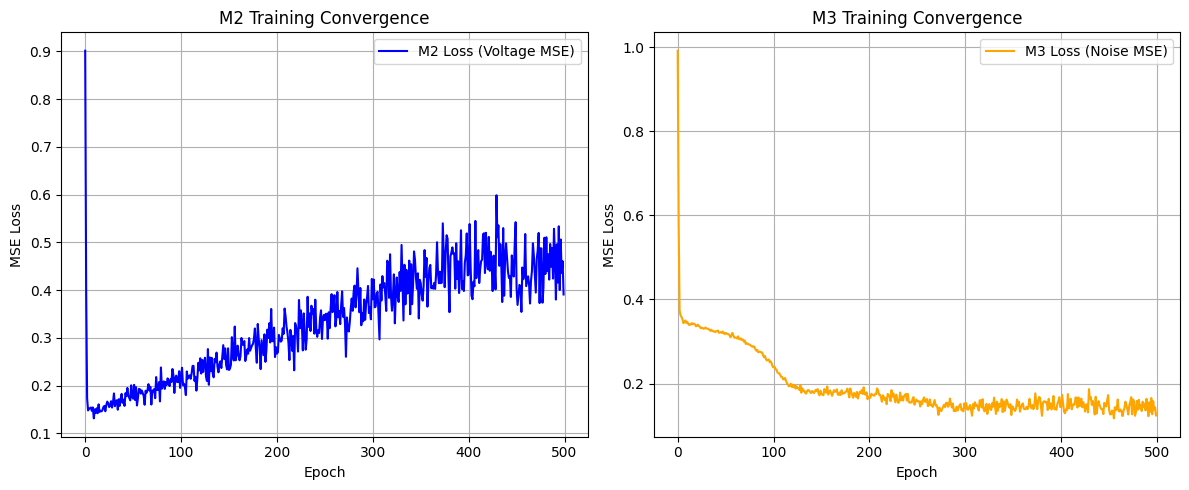

In [14]:
# 绘制训练曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history['m2'], label='M2 Loss (Voltage MSE)', color='blue')
plt.title('M2 Training Convergence')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_history['m3'], label='M3 Loss (Noise MSE)', color='orange')
plt.title('M3 Training Convergence')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(f"{MODEL_SAVE_DIR}/final_loss_curve.png")
plt.show()